In [1]:
# Importing libraries

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

In [2]:
# Pre-processing

# Resize to same dimensions and transfrom uniformly
transform =   transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, interpolation=False, fill=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Use ImageFolder for our images and labels?

C:\Users\Fisica1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\transforms\transforms.py:1428: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


     road706    speedlimit
0    road538    speedlimit
1    road510    speedlimit
2    road504    speedlimit
3    road458    speedlimit
4    road464  trafficlight
..       ...           ...
607  road247    speedlimit
608  road253    speedlimit
609  road535    speedlimit
610  road284    speedlimit
611  road723    speedlimit

[612 rows x 2 columns]
     road712    speedlimit
0    road289  trafficlight
1    road276    speedlimit
2    road262    speedlimit
3    road841     crosswalk
4    road699    speedlimit
..       ...           ...
258  road858    speedlimit
259  road455    speedlimit
260  road509    speedlimit
261  road290    speedlimit
262  road737    speedlimit

[263 rows x 2 columns]


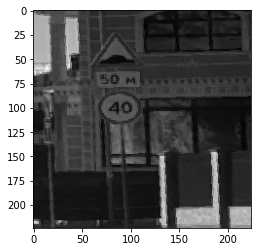

In [10]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset): 
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        print(self.img_labels)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels) 

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path+'.png').convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

training_data = CustomImageDataset(annotations_file='../dataset/train_csv.csv', img_dir='../dataset/images/', transform=transform)
validation_data = CustomImageDataset(annotations_file='../dataset/test_csv.csv', img_dir='../dataset/images/', transform=transform)

plt.imshow(training_data[0][0][0,:,:], cmap='gray')

In [11]:
# divide dataset into train-val-test subsets
indices = list(range(len(validation_data)))
np.random.shuffle(indices, )

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(f'Training size: {len(training_data)}\nValidation size: {len(val_idx)} \nTest size: {len(test_idx)}')

Training size: 612
Validation size: 211 
Test size: 52
